# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt


2022-12-19 15:19:10.106390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Import the dataset

In [48]:
# Read in the training data
data = pd.read_csv('drugsComTrain_raw.tsv', sep='\t',parse_dates = [5])


In [49]:
# Let's look at the first five rows (each row corresponds to a different drug review)
data.head()


,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,2016-11-27,37


In [50]:
# Let's see how many entries are in the training dataset
print('Total number of entries: ', len(data))


Total number of entries:  161297


In [51]:
print(data.dtypes)

Unnamed: 0              int64
drugName               object
condition              object
review                 object
rating                float64
date           datetime64[ns]
usefulCount             int64
dtype: object


We see that we have ~160,000 entries in our training set. Through the course of this project, we'll take both the rating and the usefulCount columns as our target variables. In addition to these columns, we also see that we have four features: the name of the drug, the condition being treated, the review, and the date of the review. 

We expect that characteristics of the reviews, as well as the rating and possibly the usefulCount, will depend on the condition and drug being considered. As such, we may want to construct separate models for individuals conditions and/or drugs; we'll discuss this more below. 

For the time being, let's dig into the drugName and condition features in a bit more detail.

# Features

## 1) Drug Names

Let's first determine how many different drugs are included in the training dataset.

In [52]:
print('Number of unique drugs: ', len(data.drugName.unique()))

Number of unique drugs:  3436


This is a large number of different drug names. Most drug names have just one drug, but from examining the data, we've found that some drugName entries contain more than one drug. These are combinations used in unison to treat a condition.

In [54]:
# Some drug names include more than one drug separated by "/". For instance, here are 3:
[drug for drug in data.drugName.unique() if '/' in drug][:3]


['Buprenorphine / naloxone',
 'Ethinyl estradiol / levonorgestrel',
 'Ledipasvir / sofosbuvir']

Let's see what percentage of drug names include multiple drugs separated by "/"

In [55]:
print('Percentage of drugs with names separated by "/" is {:.1f}'.format( 
      len([drug for drug in data.drugName.unique() if '/' in drug])*100/len(data.drugName.unique())))


Percentage of drugs with names separated by "/" is 9.5


We see that a little less than 10% of the total number of unique drugName entries actually contain more than one drug. We'll keep this in mind for later.

##### Counts for the top 10 drugs

We can now visualize how the drug names are distributed for the top 10 drugs

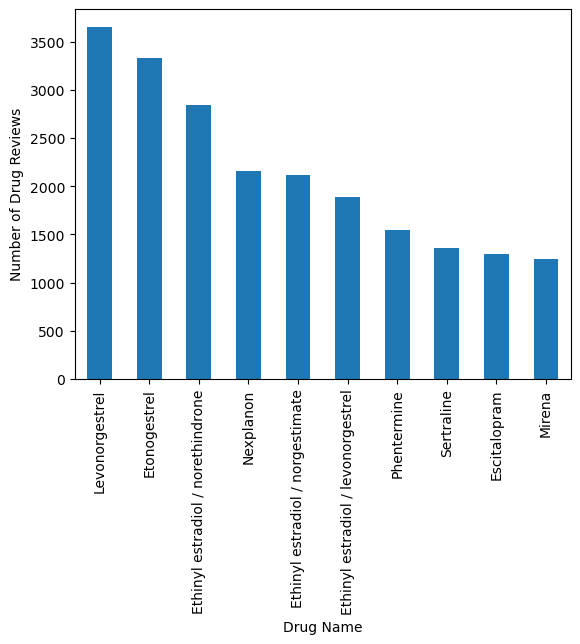

Total number of entries for top 10 drugs:  21441


In [56]:
# Obtain a histogram using value counts
%matplotlib inline
data.drugName.value_counts()[:10].plot(kind='bar')
plt.ylabel('Number of Drug Reviews');
plt.xlabel('Drug Name');
plt.show()
print("Total number of entries for top 10 drugs: ", data.drugName.value_counts()[:10].sum())

## 2) Condition


Let's see how many unique conditions are present in the dataset.

In [57]:
print('Number of unique conditions: ', len(data.condition.unique()))


Number of unique conditions:  885


We find that some conditions seem to have the usefulCount in place of the condition. These will likely need to be filtered out in our analyses.


In [58]:
# Here are the first five entries of this type
[cond for cond in data.condition.unique() if 'comment helpful' in str(cond)][:5]


['2</span> users found this comment helpful.',
 '4</span> users found this comment helpful.',
 '3</span> users found this comment helpful.',
 '11</span> users found this comment helpful.',
 '0</span> users found this comment helpful.']

Let's see if a substantial number of entries have this issue.

In [59]:
print('The total number of such entries is', len([cond for cond in data.condition.unique() if 'comment helpful' in str(cond)]))


The total number of such entries is 73


This is only a tiny fraction of the total training dataset, but still something to keep in mind.

##### Counts for the top 10 conditions

As we did with the drug names, let's see how the top conditions are distributed.

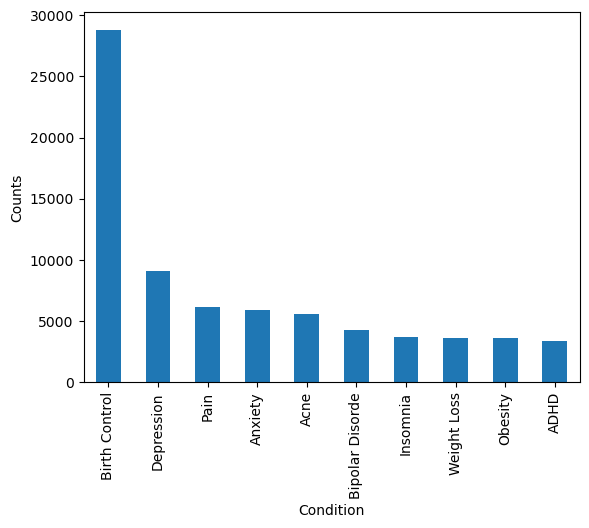

In [60]:
# Histogram of the top 10 conditions using value counts
data.condition.value_counts()[:10].plot(kind='bar')
plt.ylabel('Counts');
plt.xlabel('Condition');
plt.show()

The large number of entries for the top 10 conditions seen from the plot above suggests that a good chunk of our entries come from a handful of conditions. For instance, we can look at the percentage of entries in the top 15 conditions.

In [61]:
print('Total percentage of entries in the top 15 conditions: {:.0f}%'
      .format(sum(data.condition.value_counts()[:15])*100/len(data)))

Total percentage of entries in the top 15 conditions: 53%


As we see, more than half of the entries include conditions in the top 15 of the 885 unique conditions. This will be relevant when we see how the rating and/or usefulCount depends on the condition later on.

## 3) Review

Let's now look at the drug reviews.

Each review is a string in double quotes. Let's consider an example to get a feel for what a typical review looks like.

In [62]:
data.review[15]


'"I have been taking Saxenda since July 2016.  I had severe nausea for about a month once I got up to the 2.6 dosage.  It has since subsided and the only side effect I notice now is the dry mouth.  I make sure to drink  2.5 litres of water a day (about 10 glasses).  This helps with the weight loss as well as the constipation.  I have been reducing my dose to find a comfortable spot where I am still losing weight but don&#039;t feel like I am over medicating.  For me, 1.8 is working very well.  I also feel wearing a Fitbit has really helped.  I can track my food, water, exercise and steps - it keeps me moving more.  When this started I could barely walk the length of myself without getting winded - I have lost 58 lbs so far."'

Some reviews have special characters such as "\r" and other html entities as appear in the one above. We'll need to deal with these.

Now we can take a look at trends in the number of words per review. This will we helpful when we perform sentiment analysis.

##### Word counts

We first obtain the total number of words for each entry in the dataset.

In [63]:
# Split each review and obtain word count
word_counts = [len(r.split()) for r in data.review]


Let's see what fraction of reviews have fewer than 160 words.

In [64]:
print('Percentage of entries with fewer than 160 words is: {:.2f}'.format(
    100*np.sum(np.array(word_counts) < 160)/len(data)))


Percentage of entries with fewer than 160 words is: 99.60


And we see that nearly all of the reviews are less than 160 words long.

We can also visualize the distribution of word counts.

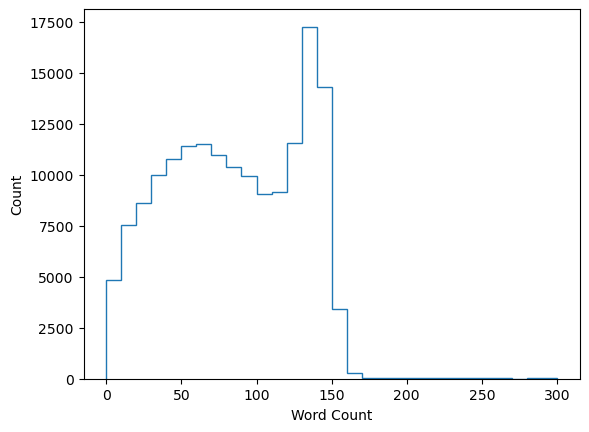

In [65]:
# Histogram of number of words in each review
plt.hist(word_counts, range=[0, 300], histtype='step', bins=30);
plt.xlabel('Word Count')
plt.ylabel('Count');


We see that that the distribution of word counts has two peaks: a wide peak around 50-60 words, and a much sharper peak around 140-150 words, followed by a very abrupt dropoff past 150 words.

Based on the fact that more than 99% of entries have fewer than 160 words, we can likely set the upper limit on review length to 160 words without too much impact for subsequent sentiment analyses.

## 4) Rating


We now move on to the rating column. Let's get a feel for the possible values that rating can take.

In [66]:
# Identify umique rating values
np.sort(data.rating.unique())


array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

We see that the rating is an integer ranging from 1-10. For convenience, we may want to shift the ratings to a 0-9 range for our analysis.

##### Distribution of ratings. 

Let's see how the ratings are distributed to see if anything stands out.

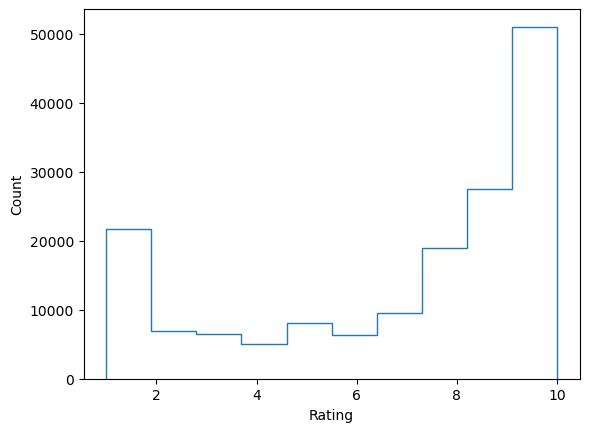

In [67]:
plt.hist(data.rating, histtype='step');
plt.xlabel('Rating')
plt.ylabel('Count');


We see that the rating are generally polarized to the extremes, which seems reasonable.

## 5) Date

Let's begin our examination of the review-date column by seeing how the dates are formatted.

In [69]:
print(data.date[0])
print(type(data.date[0]))


2012-05-20 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


The date has been parsed as a datetime object. We can more easily handle the date by converting it to the number of days after a reference date. Let's take a look at the range of dates, to determine an appropriate reference date.

In [73]:
print('The oldest date is:', data.date.min())
print('The latest date is:', data.date.max())


The oldest date is: 2008-02-24 00:00:00
The latest date is: 2017-12-12 00:00:00


The reviews span nearly 10 years in duration, beginning in 2008. Taking into account the possibility that the test set could have slightly earlier dates, we'll use a reference data of Jan 1, 2000, to be safe.

Let's now add our new feature, the number of days since Jan 1, 2000, to the dataframe. We'll call this the "no_of_days" column.

In [75]:
# Create this new feature and take a look at the first few entries
start_date = datetime.strptime('January 1, 2000', '%B %d, %Y')
data['no_of_days'] = np.array([(d-start_date).days for d in data.date]).astype(int)
data.head()


,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,no_of_days
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,2012-05-20,27,4523
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,2010-04-27,192,3769
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,2009-12-14,17,3635
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,2015-11-03,10,5785
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,2016-11-27,37,6175


And we see that the values for no_of_days seem reasonable.

##### Distribution of the number of days

 Let's see when are the reviews are created using a histogram. Note that newer entries have a larger number of days

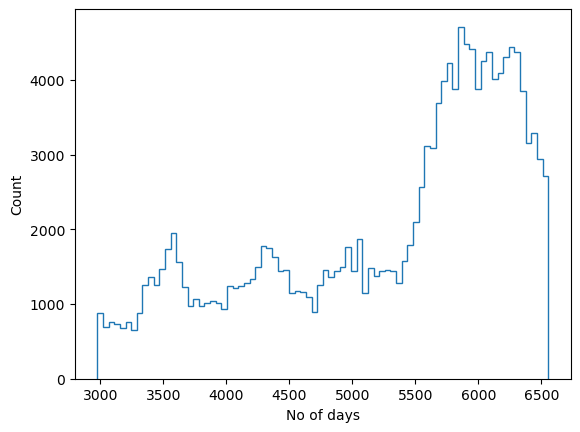

In [76]:
plt.hist(data.no_of_days, histtype='step', bins=80);
plt.xlabel('No of days')
plt.ylabel('Count');


There is a large peak of entries around 5500 days. This is likely to do with the fact that second website that the data is gathered from started around this time. Let's see how the reviews are distributed between the days of the week.

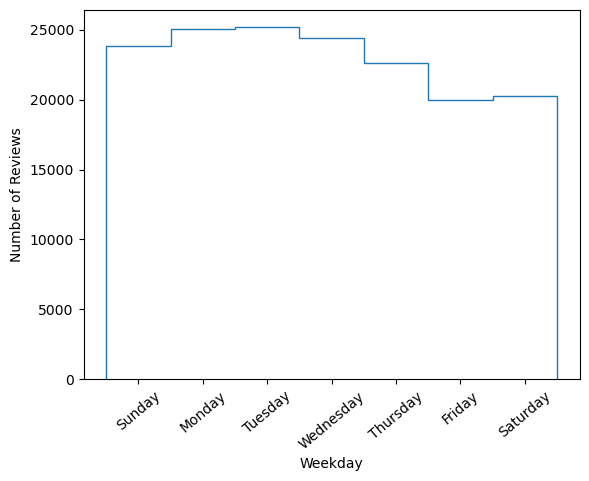

In [104]:
fig, ax = plt.subplots()
weekday_names = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

bins = range(8)
    
ax.hist(data.date.dt.dayofweek,bins = bins,histtype='step',align = 'left');
ax.set_xlabel('Weekday')
ax.set_ylabel('Number of Reviews')
ax.set_xticks(range(7));
ax.set_xticklabels(weekday_names,rotation=40);


The reviews seem relatively evenly distributed throughout the week, with a slight dip during the weekend. Let's look at how the reviews are distributed throughout the days of the month, and from month to month.


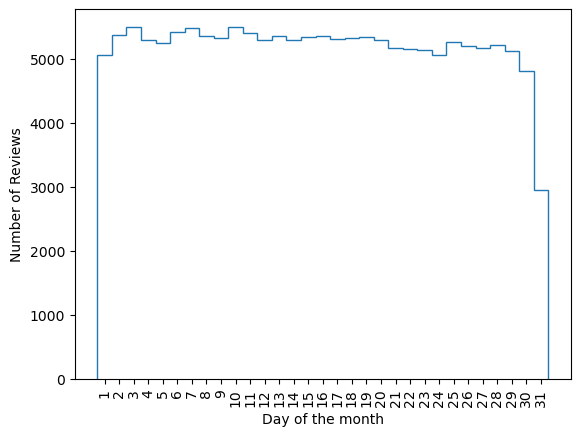

In [140]:
fig, ax = plt.subplots()

ax.hist(data.date.dt.day,bins = np.arange(0.5,32.5,1),histtype='step');
ax.set_xlabel('Day of the month')
ax.set_ylabel('Number of Reviews')
ax.set_xticks(range(1,32));
ax.set_xticklabels(range(1,32),rotation=90);

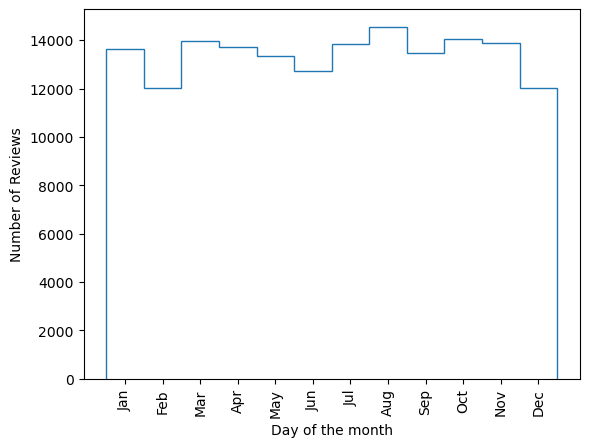

In [142]:
fig, ax = plt.subplots()

ax.hist(data.date.dt.month,bins = np.arange(0.5,13.5,1),histtype='step');
ax.set_xlabel('Day of the month')
ax.set_ylabel('Number of Reviews')
ax.set_xticks(range(1,13));
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul','Aug','Sep','Oct','Nov','Dec'],rotation=90);

Now let's see if the drug rating is correlated with the time of month or year, to see if people are (for example) more inclined to give better reviews during the holidays.

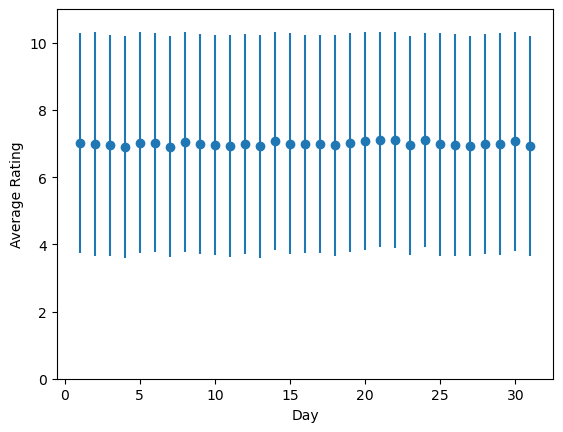

In [184]:
data['day'] = data.date.dt.day
ratings_grouped_day = data.groupby('day')
ratings_mean_std = ratings_grouped_day['rating'].agg(['mean','std'])

fig, ax = plt.subplots()
ax.errorbar(ratings_mean_std.index,ratings_mean_std['mean'], yerr = ratings_mean_std['std'], marker='o', ls='');
ax.set_xlabel('Day')
ax.set_ylabel('Average Rating')
ax.set_ylim(0,11);

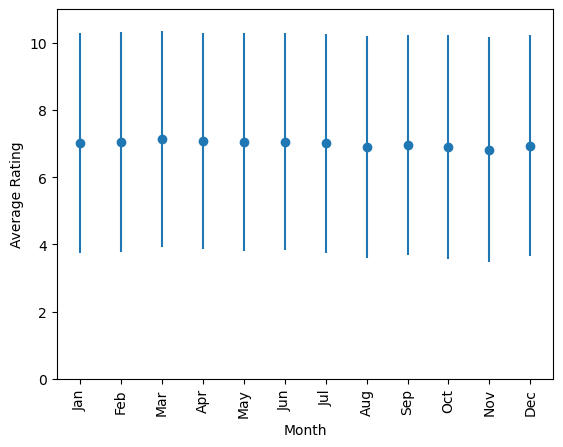

In [187]:
data['month'] = data.date.dt.month
ratings_grouped_day = data.groupby('month')
ratings_mean_std = ratings_grouped_day['rating'].agg(['mean','std'])

fig, ax = plt.subplots()
ax.errorbar(ratings_mean_std.index,ratings_mean_std['mean'], yerr = ratings_mean_std['std'], marker='o', ls='');
ax.set_xlabel('Month')
ax.set_ylabel('Average Rating')
ax.set_ylim(0,11);

ax.set_xticks(range(1,13));
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul','Aug','Sep','Oct','Nov','Dec'],rotation=90);

From these plots, it seems there is little to no correlation between the average rating and the time of month or year it was posted.

## 6) Useful Count

The useful count is an integer that tells us how many people found the review useful. Let's see the range of useful counts present in our data

In [188]:
print('Minimum Useful Count:', min(data.usefulCount))
print('Maximum Useful Count:', max(data.usefulCount))


Minimum Useful Count: 0
Maximum Useful Count: 1291


The total range of values is between 0 and 1300. We now ask what percentage have fewer than 200 useful counts (say)

In [39]:
print('Percentage of entries with fewer than 200 useful Count is: {:.1f}'.format(100*np.sum(data.usefulCount < 200)/len(data)))


Percentage of entries with fewer than 200 useful Count is: 99.5


As we see, more than 99% of ebtries have fewer than 200 useful counts, while the maximum value was 1300. This suggests that there are a few outliers in the data.

##### Distribution of useful counts

We can visualize the distribution of useful counts below 200

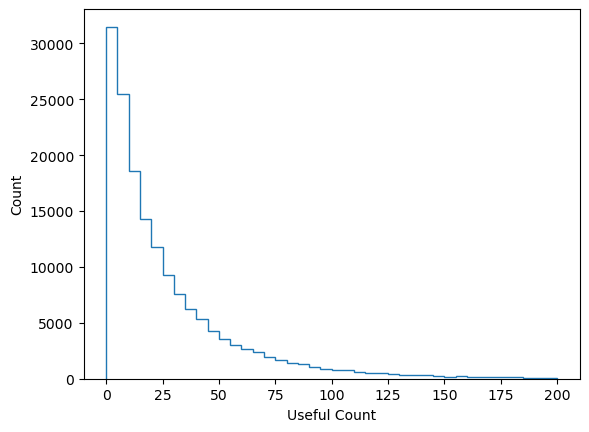

In [40]:
plt.hist(data.usefulCount, histtype='step', range=[0, 200], bins=40);
plt.xlabel('Useful Count')
plt.ylabel('Count');


We see that it decreases monotonically

Now that we have explored each relevant attribute in some detail, let's examine the relationship between two different attributes

# Relationship between different attributes

We restrict ourselves to the attributes that are numerical here. These are: rating, no_of_days, and usefulCount

## 1) Rating and Time

Let's take a look at how the average rating depends on when the review was posted

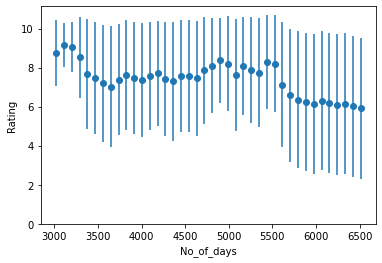

In [6]:
#Bin by number of days days and obtain the average and standard deviation of the ratings
t = pd.interval_range(data.no_of_days.min(), data.no_of_days.max(), 40)
group = data.groupby(pd.cut(data.no_of_days, t))
ratings = group.rating.apply(np.average)
ratings_sd = np.sqrt(group.rating.apply(np.var))

plt.errorbar(t.mid, ratings, yerr=ratings_sd, marker='o', ls='')
plt.ylim(0)
plt.xlabel('No_of_days')
plt.ylabel('Rating');


As we see above, there is not much correlation between the rating and number of days, as one might expect.

## 2) Useful count and Time

Similarly, let's see how the usefulCount depends on the age of the review

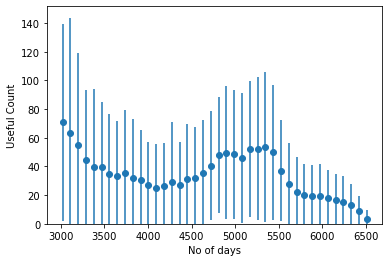

In [7]:
t = pd.interval_range(data.no_of_days.min(), data.no_of_days.max(), 40)
group = data.groupby(pd.cut(data.no_of_days, t))
usefulcounts = group.usefulCount.apply(np.average)
usefulcounts_sd = np.sqrt(group.usefulCount.apply(np.var))

# plt.plot(t.mid, usefulcounts, 'o')
plt.errorbar(t.mid, usefulcounts, yerr=usefulcounts_sd, marker='o', ls='')
plt.ylim(0)
plt.xlabel('No of days')
plt.ylabel('Useful Count');


Older Reviews have generally been found more useful by people.

## 3) Useful Count and Rating

Now that we've seen how things depend on time, we take a look at how the usefulness depends on the rating

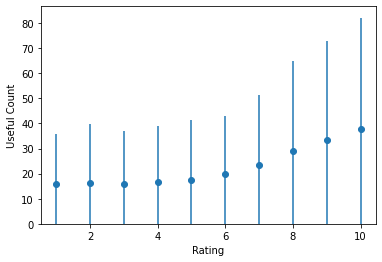

In [42]:
# The rating need not be binned as it is an integer between 1 and 10
group = data.groupby(['rating'])
usefulcounts = group.usefulCount.apply(np.average)
usefulcounts_sd = np.sqrt(group.usefulCount.apply(np.var))

plt.errorbar(group.groups.keys(), usefulcounts, yerr=usefulcounts_sd, marker='o', ls='')
plt.ylim(0)
plt.xlabel('Rating')
plt.ylabel('Useful Count');


Reviews with higher rating have been found to be more useful by people.

### Let's summarize these relationships using a correlation map

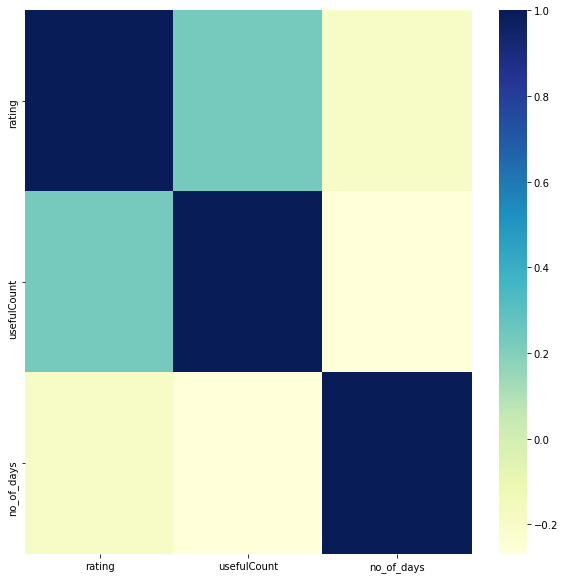

In [8]:
#Use the corr function from pandas for this
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(data[['rating', 'usefulCount', 'no_of_days']].corr(),cmap="YlGnBu")

plt.show()

##### Conclusions from the correlation plot above: Rating and Useful_Count are correlated to a higher degree than others, the least correlated are Useful_Count and no_of_days